1.403755868544601


(-0.5, 31.5, 31.5, -0.5)

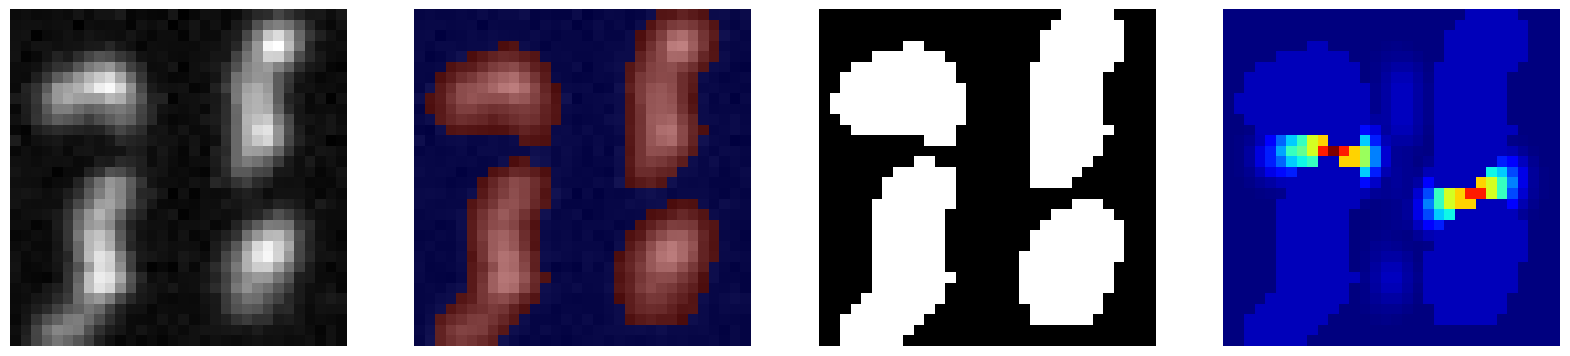

In [4]:
import numpy as np
from scipy.ndimage import distance_transform_edt
from skimage.morphology import binary_erosion, label
from PIL import Image
from os import path
import matplotlib.pyplot as plt

def find_objects(binary_mask):
    labeled_array = label(binary_mask)
    num_objects = labeled_array.max()
    return labeled_array, num_objects

def find_nearest_border(binary_mask):
    eroded = binary_erosion(binary_mask)
    border = binary_mask ^ eroded  # XOR operation to find border pixels
    return border

def create_weight_matrix(binary_mask, w0=10, sigma=1.0):
    if binary_mask.sum() == 0:
        weight_matrix = np.ones(binary_mask.shape)
        fb_ratio = 1
    else:
        labeled_array, num_objects = find_objects(binary_mask)

        dist_stack = np.zeros((32, 32, num_objects))  # List to store distances for all objects

        for obj_label in range(1, num_objects + 1):
            object_mask = (labeled_array == obj_label).astype(np.uint8)

            # Find the nearest border 1 pixel for the current object
            border_pixels = find_nearest_border(object_mask)

            # Calculate distance of 0 pixels to the nearest border 1 pixel for each object
            dist_transform = distance_transform_edt(1 - border_pixels)

            dist_transform[binary_mask == 1] = 0

            dist_stack[..., obj_label-1] = dist_transform

        # Sort the distances along the last axis to get A1 and A2
        sorted_distances = np.sort(dist_stack, axis=-1)

        A1 = sorted_distances[..., 0]  # Smallest pixel values
        A2 = sorted_distances[..., 1]  # Next smallest pixel values

        foreground = np.sum(binary_mask)
        background = binary_mask.size - foreground
        fb_ratio = background / foreground

        distance_component = w0 * np.exp(-((A1 ** 2 + A2 ** 2) / (2 * sigma**2)))
        distance_component[binary_mask == 1] = 0

        num_balance_component = np.ones(binary_mask.shape)
        num_balance_component[binary_mask == 1] = fb_ratio

        weight_matrix = distance_component + num_balance_component

    return weight_matrix, fb_ratio

# img_path = '/home/dell/Downloads/'
# img_file = 'test_mask.tif'

# mask_path = '/mnt/disk1/WZH-DataCenter/PROCESS-SPT/2023/simPSF_results/UNetDetectionDataset/20240620_SNR19-35_diffBackground_NoLocError_110nmPixSize/masks/'
# mask_file = 'Pixelized_TrackID000000000004_D07_SNR33_dT30ms_good_rep004_mask.gif'

img_path = '/mnt/disk1/WZH-DataCenter/PROCESS-SPT/2023/simPSF_results/UNetDetectionDataset/20240620_SNR19-35_diffBackground_NoLocError_110nmPixSize_3nd/imgs/'
img_file = '0620_Pixelized_TrackID004_D07_SNR33_dT30ms_good_rep003.tif'

img = Image.open(path.join(img_path,img_file))
img = np.asarray(img)
img = img.astype(np.int64)

mask_path = '/mnt/disk1/WZH-DataCenter/PROCESS-SPT/2023/simPSF_results/UNetDetectionDataset/20240620_SNR19-35_diffBackground_NoLocError_110nmPixSize_3nd/masks/'
mask_file = '0620_Pixelized_TrackID004_D07_SNR33_dT30ms_good_rep003_mask.gif'

mask = Image.open(path.join(mask_path,mask_file))
mask = np.asarray(mask)
mask = mask.astype(np.int64)
# img = np.zeros((32,32))
# plt.imshow(mask,cmap='jet')

# Assuming 'img' is your binary mask image
weight_matrix, fb_ratio  = create_weight_matrix(mask, w0=10, sigma=2)
print(fb_ratio)
# plt.imshow(weight_matrix,cmap='jet')


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 8),sharex=False, sharey=False)
ax = axes.ravel()
ax[0].imshow(img, cmap='gray')
ax[0].axis('off')
ax[1].imshow(img, cmap='gray')
ax[1].imshow(mask, cmap='jet', alpha=0.5)
ax[1].axis('off')
ax[2].imshow(mask, cmap='gray')
ax[2].axis('off')
ax[3].imshow(weight_matrix, cmap='jet')
ax[3].axis('off')


39.96


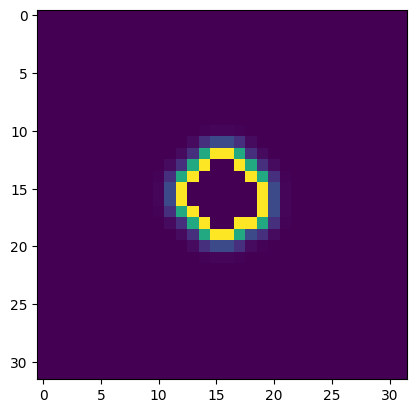

In [24]:
import numpy as np
from scipy.ndimage import distance_transform_edt
from skimage.morphology import binary_erosion, binary_dilation
from PIL import Image
from os import path
import matplotlib.pyplot as plt

def find_nearest_border(binary_mask):
    eroded = binary_erosion(binary_mask)
    border = binary_mask ^ eroded  # XOR operation to find border pixels

    # dilated = binary_dilation(binary_mask)
    # eroded = binary_erosion(dilated)
    # border = eroded ^ dilated  # XOR operation to find border pixels
    return border

def create_weight_matrix(binary_mask, w0=10, sigma=1.0):
    # Find the nearest border 1 pixel
    border_pixels = find_nearest_border(binary_mask)

    # Calculate distance of 0 pixels to the nearest border 1 pixel
    dist_transform = distance_transform_edt(1-border_pixels)
    
    # Component to compensate number balance of 0 and 1
    # num_balance_component = np.ones(binary_mask.shape)
    foreground = np.sum(binary_mask)
    background = binary_mask.size - foreground
    fb_ratio = background / foreground
    # num_balance_component[binary_mask == 1] = fb_ratio
    
    # Weight calculation using normal distribution based on distance to border
    distance_component = w0*np.exp(-dist_transform ** 2 / (2 * sigma**2))+1
    distance_component[binary_mask == 1] = 1
    # weight_matrix = num_balance_component + distance_component
    weight_matrix = distance_component
    
    return weight_matrix, distance_component, border_pixels, fb_ratio

img_path = '/mnt/disk1/WZH-DataCenter/PROCESS-SPT/2023/simPSF_results/UNetDetectionDataset/20240525_SNR19-45_NoLocError_110nmPixSize/masks'
img_file = 'Pixelized_TrackID000000000001_D01_SNR36_dT30ms_good_mask.gif'

# img_path = '/home/dell/Downloads/'
# img_file = 'test_mask.tif'
img = Image.open(path.join(img_path,img_file))
img = np.asarray(img)
img = img.astype(np.int64)


# Assuming 'img' is your binary mask image
weight_matrix, distance_component, border_pixels, fb_ratio  = create_weight_matrix(img, w0=1, sigma=1.0)
print(fb_ratio)
plt.imshow(weight_matrix)

In [28]:
A = np.array([
    [0,0,1,1,1],
    [1,0,0,1,1],
    [0,0,1,1,0],
])

dis = distance_transform_edt(A)
print(dis)

border_pixels

[[0.         0.         1.         1.41421356 2.        ]
 [1.         0.         0.         1.         1.        ]
 [0.         0.         1.         1.         0.        ]]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

IndexError: index 2 is out of bounds for axis 0 with size 2

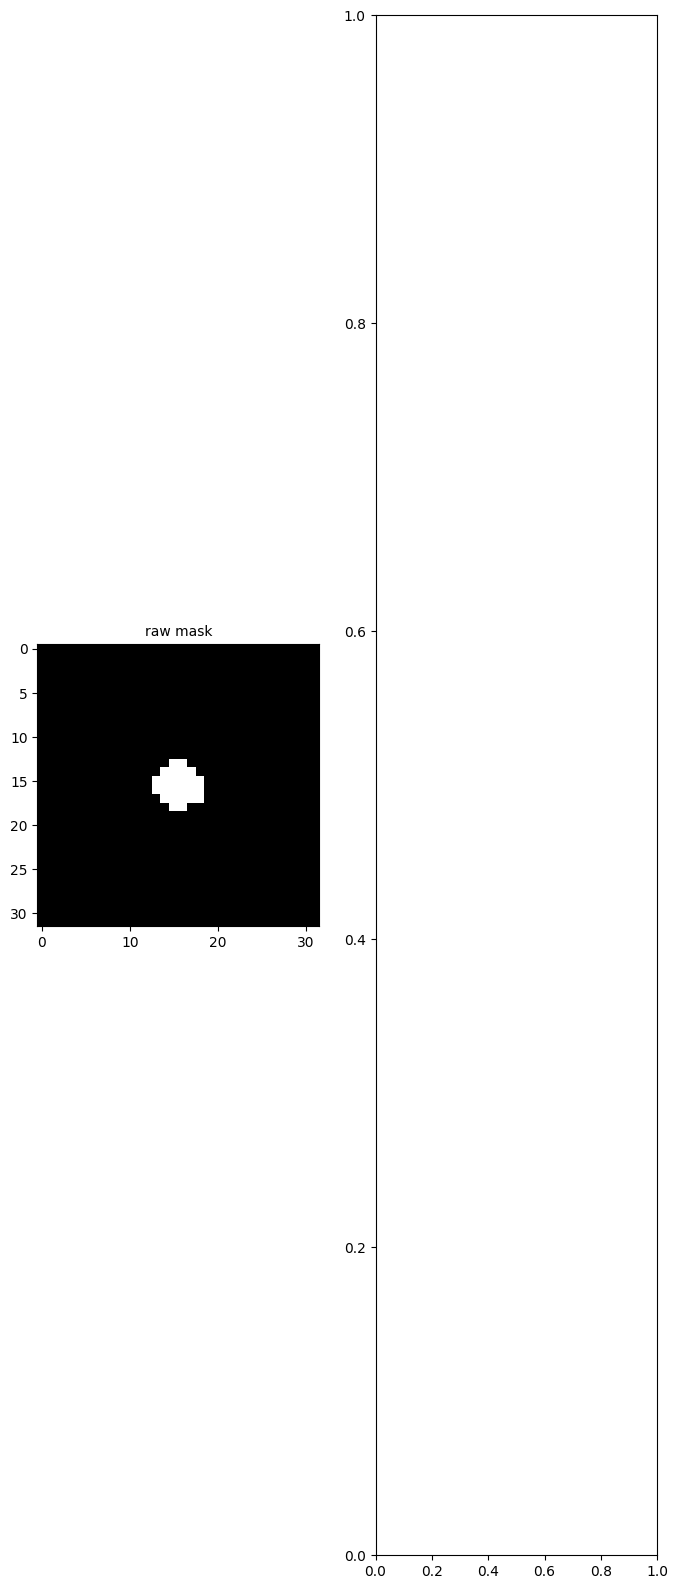

In [23]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 20),sharex=False, sharey=False)
ax = axes.ravel()
ax[0].imshow(img, cmap='gray')
# ax[0].plot(x0, y0, 'ro',markersize=3)
ax[0].set_title('raw mask', fontsize=10)

# ax[1].imshow(border_pixels, cmap='gray')
# ax[1].set_title('border_pixels', fontsize=10)

# ax[2].imshow(num_balance_component, cmap='gray')
# ax[2].set_title('num_balance_component', fontsize=10)

# ax[3].imshow(distance_component, cmap='jet')
# ax[3].set_title('distance_component', fontsize=10)

ax[2].imshow(weight_matrix, cmap='jet')
ax[2].set_title('weight_matrix', fontsize=10)

